<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day4_of_00_Gene_Relationships_in_Treutlein_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install phate scprep gseapy

     |████████████████████████████████| 102kB 3.1MB/s 
     |████████████████████████████████| 532kB 8.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 419kB 12.8MB/s 
     |████████████████████████████████| 215kB 14.6MB/s 
     |████████████████████████████████| 1.8MB 16.7MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 153kB 20.2MB/s 
     |████████████████████████████████| 5.2MB 26.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 235kB 37.5MB/s 
  Created wheel for bioservices: filename=bioservices-1.7.4-cp36-none-any.whl size=218907 sha256=d823ee9c584df274554f52e0414b78415690a5fae073bd90c43da94e0cab86de
  Stored in directory: /root/.cache/pip/wheels/ca/b9/e9/51a32c2cbaa43565ace5090261e29a8237b902995f1a2d0985
  Created wheel for easydev: filename=easydev-0.9.38-cp36-none-any.whl size=72215 sha256=e3e53e89cf8a0f2df4d87d18084c6b078c

In [0]:
import scprep

In [3]:
scprep.io.download.download_google_drive("10FpYcwqXBrG_K0p5Cq936lmH6F9sO70x", 'r_packages.tar.gz')
!tar xzf r_packages.tar.gz  -C /usr/local/lib/R/site-library/ && rm r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!pip install --upgrade rpy2
!R -e "BiocManager::install('slingshot')"

Selecting previously unselected package libgslcblas0:amd64.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../libgslcblas0_2.4+dfsg-6_amd64.deb ...
Unpacking libgslcblas0:amd64 (2.4+dfsg-6) ...
Selecting previously unselected package libgsl23:amd64.
Preparing to unpack .../libgsl23_2.4+dfsg-6_amd64.deb ...
Unpacking libgsl23:amd64 (2.4+dfsg-6) ...
Selecting previously unselected package libgsl-dev.
Preparing to unpack .../libgsl-dev_2.4+dfsg-6_amd64.deb ...
Unpacking libgsl-dev (2.4+dfsg-6) ...
Setting up libgslcblas0:amd64 (2.4+dfsg-6) ...
Setting up libgsl23:amd64 (2.4+dfsg-6) ...
Setting up libgsl-dev (2.4+dfsg-6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 174kB 2.5MB/s 
  Created wheel for rpy2: filename=rpy2-3.3.3-cp36

In [4]:
import pandas as pd
import numpy as np

import phate
import scprep
import gseapy

import matplotlib.pyplot as plt
import seaborn as sns

import time, os, tarfile

Creating directory /root/.config/bioservices 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Identifying branch-specific gene trends in the Treutlein fibroblast data

In this exercise, we will Slingshot on a dataset of 392 cells generated from trans-differentiating fibroblasts from [Treutlein et al. _Nature_. 2016](http://doi.org/10.1038/nature18323). This data was already preprocessed and downloaded from the [Dynverse quickstart tutorial](https://dynverse.org/users/2-quick_start/).

Briefly, a variety of transcription factors were overexpressed in Mouse Embryonic Fibroblasts (MEFs) to induce neuronal differentiation. Cells were sampled at several intervals over 22 days of differentation and sequenced using the Fluidigm C1 system and the SMART-seq protocol.

Once we have identified the three branches in this dataset, we are going to use DREMI to identify branch-specific trends in gene expression.

## Loading and visualizing the data

#### Download data from Google Drive

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated cell types. Replace all references to `metadata['annotated_clusters']` with an entry from `metadata`, or your favorite gene.

In [0]:
scprep.io.download.download_google_drive(id='1DDZkLhC-VlTi-_J7Mxc9_ZmKTuRMfXTG',
                                         destination='data.pickle.gz')
scprep.io.download.download_google_drive(id='1NajeoociZ6FlrW110jFbe___htfhSlNv',
                                         destination='metadata.pickle.gz')
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

#### Run PHATE

In [6]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 392 observations and 2000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.28 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.19 seconds.
Calculated PHATE in 0.60 seconds.


## Running Slingshot

Here we're just going to run the minimal code to run Slingshot with five clusters. We'll use PHATE clustering, which runs k-means on the PHATE diffusion potential, and generates results similar to spectral clustering. For a more in depth tutorial on Slingshot, please see the TrajectoryInference series.

#### Generate Clusters

In [0]:
clusters = phate.cluster.kmeans(phate_op, n_clusters=5)
metadata['cluster'] = clusters

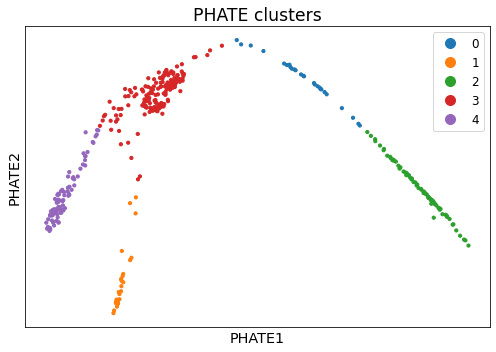

In [8]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                 label_prefix='PHATE', ticks=None,
                 title='PHATE clusters', legend_anchor=(1,1),
                 figsize=(7,5))

#### Run Slingshot

In [9]:
results = scprep.run.Slingshot(data_phate, metadata['cluster'])

R[write to console]: Using full covariance matrix


#### Grab output from `results` dictionary

In [10]:
results.keys()

dict_keys(['pseudotime', 'curves', 'branch'])

In [11]:
pseudotime = results['pseudotime']
metadata['slingshot1'] = pseudotime.iloc[:,0]
metadata['slingshot2'] = pseudotime.iloc[:,1]

metadata['slingshot_branch'] = results['branch']
metadata.head()

,annotated_clusters,cluster,slingshot1,slingshot2,slingshot_branch
0,,,,,
1_iN1_C01,d2_induced,3,0.127107,0.126734,0
1_iN1_C02,d2_induced,3,0.118734,0.117711,0
1_iN1_C03,d2_induced,3,0.126009,0.124955,0
1_iN1_C04,d2_intermediate,0,0.068607,0.068483,0
1_iN1_C05,d2_intermediate,0,0.075723,0.075491,0


#### Plotting the principal curves and branch pseudotimes


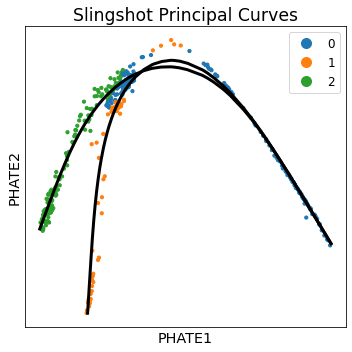

In [12]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['slingshot_branch'],
                 label_prefix='PHATE', ticks=None,
                 title='Slingshot Principal Curves',
                 figsize=(5,5))

# `results['curves']` returns as tensor (an array of arrays)
# Each array contains coordinates for the curves in the dimensionality reduced space
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k', linewidth=3)

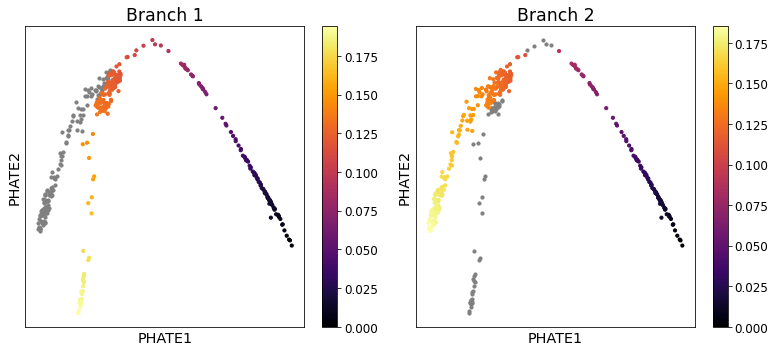

In [13]:
fig, axes = plt.subplots(1,2, figsize=(11,5))

for i, ax in enumerate(axes):
    curr_pseudotime = metadata['slingshot{}'.format(i+1)]
    m = ~pd.isnull(curr_pseudotime)
    # plot null points as grey
    scprep.plot.scatter2d(data_phate[~m], color='grey', s=10,
                          ax=ax)    
    # plot points on branch
    scprep.plot.scatter2d(data_phate[m], c=curr_pseudotime[m], s=10,
                         label_prefix='PHATE', ticks=None,
                          title='Branch {}'.format(i + 1),
                          ax=ax)
    
fig.tight_layout()

## Identifying branch-specific changes in gene expression

Now that we have our slingshot results, we can start using DREMI to identify genes with strong statistical association with pseudotime on each branch. DREMI is an estimate of mutual information designed to work with the sparsity of data in single-cell experiments. There is an implementation of DREMI in `scprep` at `scprep.stats.knnDREMI`.


#### Create masks for each of the branches

In [0]:
branch0 = results['branch'] == 0
branch1 = results['branch'] == 1 
branch2 = results['branch'] == 2

#### Calculating kNN-DREMI for each branch

This will take some time because we calculate kNN-DREMI on all genes three times.

In [16]:
dremi_branch0 = np.zeros(data.shape[1])
dremi_branch1 = np.zeros(data.shape[1])
dremi_branch2 = np.zeros(data.shape[1])

data_branch0 = data.loc[branch0]
data_branch1 = data.loc[branch1]
data_branch2 = data.loc[branch2]

pseudotime_branch0 = results['pseudotime'].loc[branch0].mean(axis=1)
pseudotime_branch1 = results['pseudotime'].loc[branch1][0]
pseudotime_branch2 = results['pseudotime'].loc[branch2][1]

for i, gene in enumerate(data):
    dremi_branch0[i] = scprep.stats.knnDREMI(pseudotime_branch0, data_branch0[gene])
    dremi_branch1[i] = scprep.stats.knnDREMI(pseudotime_branch1, data_branch1[gene])
    dremi_branch2[i] = scprep.stats.knnDREMI(pseudotime_branch2, data_branch2[gene])

/usr/local/lib/python3.6/dist-packages/scprep/stats.py:204: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning,
/usr/local/lib/python3.6/dist-packages/scprep/stats.py:204: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning,
/usr/local/lib/python3.6/dist-packages/scprep/stats.py:204: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning,
/usr/local/lib/python3.6/dist-packages/scprep/stats.py:204: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning,


#### Calculate the difference between DREMI scores on branch 1 and branch 2
How do you calculate the difference between the branch1 and branch2 DREMI scores?

In [0]:
# ===========
# Subtract branch 1 from branch 2
diff = dremi_branch0[i] - dremi_branch1[i]
# ===========

#### Get the genes with highest association with each branch

You will need to write the code to concatenate the arrays

In [19]:
branch0_genes = data.columns[np.argsort(dremi_branch0)[::-1][:30]]
# Here we sort by the difference in DREMI scores to get the most negative values
branch1_genes = data.columns[np.argsort(diff)[::-1][:10]]

# Here we sort by the difference in DREMI scores to get the largest values
branch2_genes = data.columns[np.argsort(diff)[:10]]

# ========
# Add code to concatenate the lists of genes for each branch
# Make sure the output is a 1-dimensional array and does not contain duplicates
interesting_genes = ['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14']
# ========
interesting_genes

['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14']

#### Reordering the dataset by branch

Currently, the dataset is not ordered any way in particular, which can be frustrating for plotting. You can see this if we plot the pseudotime values in order.

You'll need to add code to calculate the average pseudotime for each point.

In [0]:
# =======
# Add code to calculate average pseudotime per cell here
# Note: you may find the function `np.nanmean` helpful
mean_pseudotime = 

branch_ids = np.unique(branch)
    branch_means = [
        np.nanmean(slingshot["pseudotime"][branch == id])
        if not np.all(np.isnan(slingshot["pseudotime"][branch == id]))
        else np.nan
        for id in branch_ids
    ]
    branch_order = np.argsort(branch_means)
    branch_old = branch.copy()
    for i in range(len(branch_order)):
        j = branch_order[i]
        if np.isnan(branch_means[j]):
            branch[branch_old == branch_ids[j]] = -1
        else:
            branch[branch_old == branch_ids[j]] = i
    slingshot["branch"] = branch

    if index is not None:
        slingshot["pseudotime"] = pd.DataFrame(slingshot["pseudotime"], index=index)
        slingshot["branch"] = pd.Series(slingshot["branch"], name="branch", index=index)
    return slingshot

# =======

scprep.plot.scatter(np.arange(results['pseudotime'].shape[0]),
                    mean_pseudotime,
                    c=results['branch'],
                    xlabel="Data index",
                    ylabel="Pseudotime",
                    legend_title="Branch")

Here, we reorder the cells, first by branch and then by pseudotime.

In [0]:
pseudotime_order = np.zeros(data.shape[0], dtype=int)
raw_indices = np.arange(data.shape[0], dtype=int)

block_masks = [branch0, (branch1 & ~branch2), (branch2 & ~branch1)]

block_start = 0
for block_mask in block_masks:
    block_len = np.sum(block_mask)
    block_end = block_start + block_len
    pseudotime_order[block_start:block_end] = raw_indices[block_mask][np.argsort(results['pseudotime'].loc[block_mask].sum(axis=1))]
    block_start = block_end

In [0]:
scprep.plot.scatter(np.arange(results['pseudotime'].shape[0]),
                    np.nanmean(results['pseudotime'], axis=1)[pseudotime_order],
                    c=results['branch'][pseudotime_order],
                    xlabel="Data index",
                    ylabel="Pseudotime",
                    legend_title="Branch")

#### Creating a `clustermap` of the top genes

In [0]:
# Creating colors for each column
branch_cmap = {0:'#a6cee3', 1:'#1f78b4', 2:'#b2df8a'}
branch_colors = np.array([branch_cmap[b] for b in results['branch']])

pseudotime_colors = plt.cm.inferno(mean_pseudotime/np.max(mean_pseudotime))

cg = sns.clustermap(data.iloc[pseudotime_order][interesting_genes].T, 
               col_colors=[branch_colors[pseudotime_order], pseudotime_colors[pseudotime_order]], 
                    col_cluster=False,
                   yticklabels=data.iloc[pseudotime_order][interesting_genes].T.index,
                   xticklabels=[])

cg.ax_heatmap.set_xlabel('Cells', fontsize=18)

cg.fig.set_size_inches(15,15)

## Gene set enrichment

Although this heatmap looks nice and is interesting in its own right, it is also important to make sure that these genes are biologically interesting. Now, we're going to use EnrichR to perform gene set enrichment on the genes that are unique to each branch. There are many ways to perform gene set enrichement analysis, but we're going to focus on EnrichR. The following test from [Chen E, et al. BMC Bioinformatics (2013)](https://doi.org/10.1186/1471-2105-14-128) describes how EnrichR calculates gene set enrichement.

> **Computing enrichment**  
Enrichr implements three approaches to compute enrichment. The first one is a standard method implemented within most enrichment analysis tools: the Fisher exact test. This is a proportion test that assumes a binomial distribution and independence for probability of any gene belonging to any set. The second test is a correction to the Fisher exact test that we developed based on intuition. We first compute enrichment using the Fisher exact test for many random input gene lists in order to compute a mean rank and standard deviation from the expected rank for each term in each gene-set library. Then, using a lookup table of expected ranks with their variances, we compute a z-score for deviation from this expected rank, this can be a new corrected score for ranking terms. Alternatively, we combined the p-value computed using the Fisher exact test with the z-score of the deviation from the expected rank by multiplying these two numbers as follows:

$$c=log(p)\cdot z$$

>Where $c$ is the combined score, $p$ is the p-value computed using the Fisher exact test, and $z$ is the z-score computed by assessing the deviation from the expected rank. Enrichr provides all three options for sorting enriched terms. In the results section, we show how we evaluated the quality of each of these three enrichment methods by examining how the methods rank terms that we know should be highly ranked.

### Getting gene sets from https://amp.pharm.mssm.edu/Enrichr/
In this exercise, we're going to leave colab for a little bit to introduce you to the HTML5 version of EnrichR. 

1. For each branch, get a list of 100 "interesting" genes [as calculated above](#Get-the-genes-with-highest-association-with-each-branch).
2. Print out the list in the following code block
3. Copy the gene symbols
4. Copy them into https://amp.pharm.mssm.edu/Enrichr/
5. Examine gene set enrichment for each Gene Ontology (GO) category under the "Ontologies" tab

Using these lists, can you determine which branch is the differentiating muscle cells and the differentiating neurons?

In [0]:
# =======
# Rerun the interesting genes calculation with 100 genes from each branch
branch0_genes = 
branch1_genes = 
branch2_genes = 
interesting_genes = 
# ========
interesting_genes

In [0]:
for gene in branch0_genes:
    print(gene)

### Running EnrichR from gseapy

There is also a handy tool for performing GSEA in Python called gseapy. Documentation for the tool is available at: https://gseapy.readthedocs.io/en/master/

#### Getting the enrichement for all the "interesting genes" used in the heatmap above

In [0]:
# gseapy needs the gene list as a list, not np.array
gene_list = list(interesting_genes)
gseapy.enrichr(gene_list, 'GO_Biological_Process_2018', outdir='Enrichr')
# Load the output into a DataFrame
enrichr_results = pd.read_csv('./Enrichr/GO_Biological_Process_2018..enrichr.reports.txt', sep='\t')

#### Examining the output table

What do you notice about the genes enriched in each category? How does overlap affect the Combined Score?

In [0]:
enrichr_results = enrichr_results.sort_values('Combined Score', ascending=False).reset_index(drop=True)
enrichr_results.head()

#### Plot a bar chart of the  10 highest Combined Score values

You'll need to add code for:
1. Select the first 10 rows of the DataFrame
2. Getting the `'Combined Score'` from the `row` variable
3. Completing the command to `ax.bar` to get a **vertical** bar chart.

In [0]:
fig, ax = plt.subplots(1, figsize=(10,8))
# ======
# Select the first 10 rows from `enrichr_results`
top_gene_sets = 
# ======

ticks = []
ticklabels = []

for i, row in top_gene_sets.iterrows():
    # ======
    # Get the 'Combined Score' value from the row
    combined_score =
    ax.bar(x= , height= , color='red')
    # ======

    # Append the x position to the ticks list
    ticks.append(i)
    # Append the 'term' column to the ticklabels list
    ticklabels.append(row['Term'])

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontsize=16)